In [6]:
import pathlib
import sys
import math
module_dir = pathlib.Path("").parent.resolve()
root_dir = module_dir.parent
source_dir = root_dir.joinpath("source")
model_dir = root_dir.joinpath("model")
asvlite_wrapper_dir = root_dir.joinpath("dependency", "ASVLite", "wrapper", "cython")
sys.path.insert(0, str(source_dir))
sys.path.insert(0, str(asvlite_wrapper_dir))

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from autosklearn.regression import AutoSklearnRegressor

In [9]:
from joblib import load

## Load training data

In [10]:
validation_data_file = "../results/glider_thrust/tuning/tuning_factors_for_validation.csv"
cols_to_use = ["Timestamp(UTC)",
               "distance(m)",
               "delta_T(s)",
               "delta_T_simulated(s)",
               "speed(knots)",
               "speed_simulated(knots)",
               "simulated_wave_height(m)", 
               "current(knots)", 
               "relative_current_direction", 
               "tuning_factor",
               "error_msg"]
df = pd.read_csv(validation_data_file, usecols = cols_to_use)
df["relative_current_direction(abs)"] = df["relative_current_direction"].abs()

# Find the proportion of training data for which the tuning factor was computed.
count_rows = len(df)
count_rows_with_tuning = len(df["tuning_factor"].dropna()) 
count_rows_no_tuning = count_rows - count_rows_with_tuning
print("Number of voyage segments for which tuning factor was not computed = {}.".format(count_rows_no_tuning))
print("Tuning factor was computed for {:.2f}% of segments.".format(100*count_rows_with_tuning/count_rows))

df = df[df["tuning_factor"].notna()]
df.reset_index(drop=True, inplace=True)

Number of voyage segments for which tuning factor was not computed = 596.
Tuning factor was computed for 94.23% of segments.


In [11]:
# Group segments based on simuated wave heights
for i in range(len(df)):
    df.loc[i, "tuning_group"] = int(math.ceil(df.loc[i, "simulated_wave_height(m)"]))

## Explore the training data

<AxesSubplot: xlabel='simulated_wave_height(m)', ylabel='tuning_factor'>

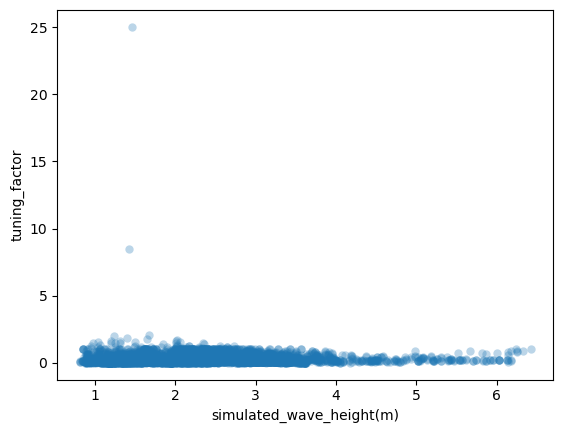

In [12]:
# Scatter plot all tuning factors
sns.scatterplot(data=df, x="simulated_wave_height(m)", y="tuning_factor", alpha=0.3, linewidth=0)

<AxesSubplot: xlabel='tuning_group', ylabel='tuning_factor'>

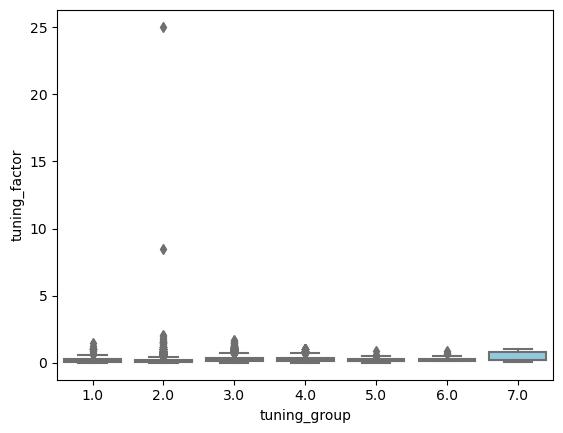

In [13]:
sns.boxplot(data=df, y="tuning_factor", x="tuning_group", color='skyblue')

In [14]:
# Remove outliers and replot
q_1  = df["tuning_factor"].quantile(0.01)
q_99 = df["tuning_factor"].quantile(0.99)
df = df[(df["tuning_factor"] < q_99) & (df["tuning_factor"] > q_1)]

<AxesSubplot: xlabel='simulated_wave_height(m)', ylabel='tuning_factor'>

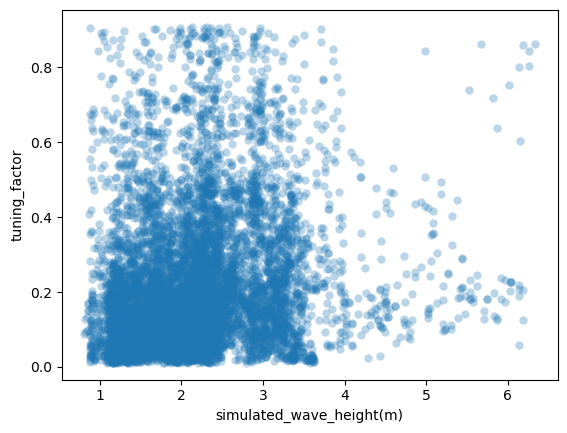

In [15]:
sns.scatterplot(data=df, x="simulated_wave_height(m)", y="tuning_factor", alpha=0.3, linewidth=0)

<AxesSubplot: xlabel='tuning_group', ylabel='tuning_factor'>

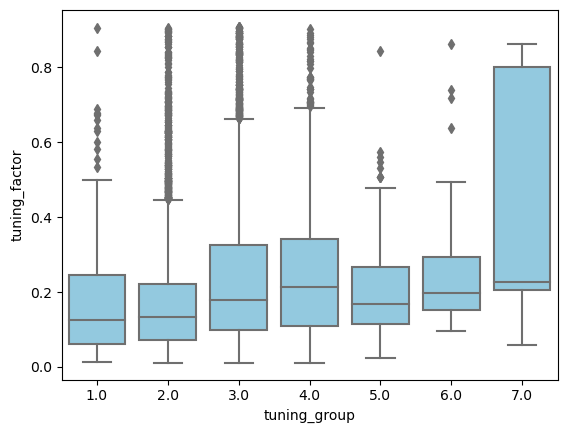

In [16]:
sns.boxplot(data=df, y="tuning_factor", x="tuning_group", color='skyblue')

## Thrust tuning factor models

In [17]:
df["simulated_wave_height(m)"].describe()

count    9398.000000
mean        2.165153
std         0.753385
min         0.810379
25%         1.638387
50%         2.103276
75%         2.501477
max         6.332589
Name: simulated_wave_height(m), dtype: float64

In [18]:
df["current(knots)"].describe()

count    9398.000000
mean        0.308225
std         0.184801
min         0.001166
25%         0.172161
50%         0.277234
75%         0.394088
max         1.392472
Name: current(knots), dtype: float64

In [19]:
X = df[["simulated_wave_height(m)", "current(knots)", "relative_current_direction(abs)"]].values
y = df["tuning_factor"].values

### Model 1 - Linear regression based only on wave height

In [20]:
# Load the model from file
file_name = model_dir.joinpath("thrust_tuning_lin_reg_1.joblib")
model_1 = load(str(file_name)) 

In [21]:
# Test model performance
y_hat = model_1.predict(np.array([row[0] for row in X]).reshape(-1, 1))
model_1_mse = mean_squared_error(y, y_hat)
model_1_r2  = r2_score(y, y_hat)
print("mse = {}".format(model_1_mse))
print("r2 = {}".format(model_1_r2))

mse = 0.0327205389180671
r2 = -0.013900416502628188


<AxesSubplot: >

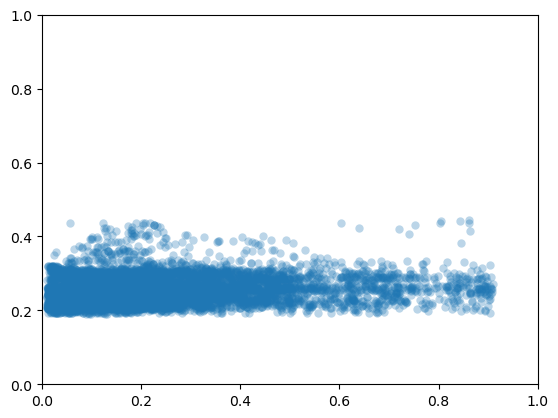

In [22]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y, y=y_hat, alpha=0.3, linewidth=0)

### Model 2 - Linear regression using wave height, current speed and direction

In [23]:
# Load the model from file
file_name = model_dir.joinpath("thrust_tuning_lin_reg_2.joblib")
model_2 = load(str(file_name)) 

In [24]:
# Test model performance
y_hat = model_2.predict(X)
model_2_mse = mean_squared_error(y, y_hat)
model_2_r2  = r2_score(y, y_hat)
print("mse = {}".format(model_2_mse))
print("r2 = {}".format(model_2_r2))

mse = 0.03279205959580764
r2 = -0.01611660386834557


<AxesSubplot: >

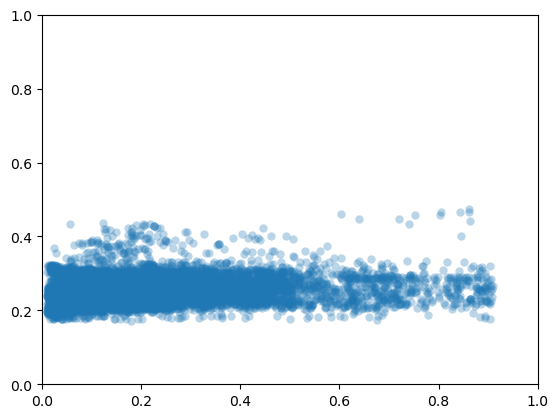

In [25]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y, y=y_hat, alpha=0.3, linewidth=0)

### Model 3 - XGBoost

In [26]:
# Load the model from file
file_name = model_dir.joinpath("thrust_tuning_xgboost.joblib")
model_3 = load(str(file_name)) 

In [27]:
# Test model performance
y_hat = model_3.predict(X)
model_3_mse = mean_squared_error(y, y_hat)
model_3_r2  = r2_score(y, y_hat)
print("mse = {}".format(model_3_mse))
print("r2 = {}".format(model_3_r2))

mse = 0.035871450583258774
r2 = -0.11153666441713983


<AxesSubplot: >

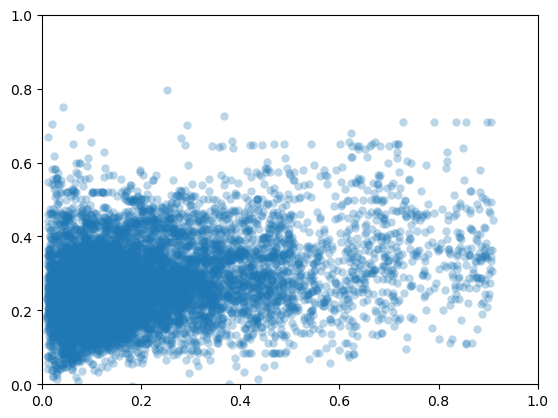

In [28]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y, y=y_hat, alpha=0.3, linewidth=0)

### Model 4 - AutoML

In [29]:
# Load the model from file
file_name = model_dir.joinpath("thrust_tuning_automl.joblib")
model_4 = load(str(file_name)) 

In [30]:
# Test model performance
y_hat = model_4.predict(X)
model_4_mse = mean_squared_error(y, y_hat)
model_4_r2  = r2_score(y, y_hat)
print("mse = {}".format(model_4_mse))
print("r2 = {}".format(model_4_r2))
print(model_4.sprint_statistics())
print(model_4.leaderboard())

mse = 0.0349380594514247
r2 = -0.08261398500479422
auto-sklearn results:
  Dataset name: 888d5553-bfd7-11ed-b40b-4851b716dee7
  Metric: r2
  Best validation score: 0.517750
  Number of target algorithm runs: 142
  Number of successful target algorithm runs: 103
  Number of crashed target algorithm runs: 19
  Number of target algorithms that exceeded the time limit: 6
  Number of target algorithms that exceeded the memory limit: 14

          rank  ensemble_weight               type      cost   duration
model_id                                                               
140          1             0.34        extra_trees  0.482250   8.633009
20           2             0.30        extra_trees  0.486113   7.562999
41           3             0.16  gradient_boosting  0.530353   3.742911
98           4             0.14  gradient_boosting  0.592009  19.511256
125          5             0.06      random_forest  0.678659   6.783355


<AxesSubplot: >

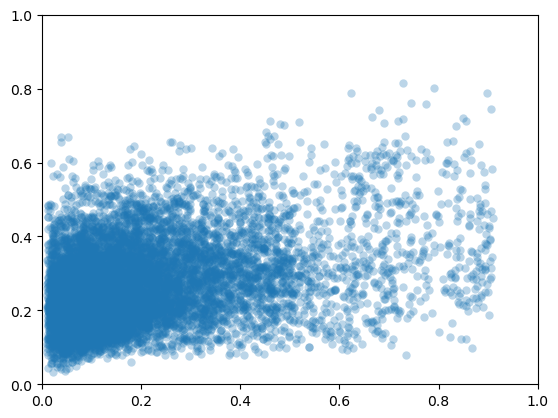

In [31]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y, y=y_hat, alpha=0.3, linewidth=0)

### Model 5 - Linear regression with uniform population 

In [33]:
# Load the model from file
file_name = model_dir.joinpath("thrust_tuning_lin_reg_3.joblib")
model_5 = load(str(file_name)) 

In [36]:
# Test model performance
y_hat = model_5.predict(np.array([row[0] for row in X]).reshape(-1, 1))
model_5_mse = mean_squared_error(y, y_hat)
model_5_r2  = r2_score(y, y_hat)
print("mse = {}".format(model_5_mse))
print("r2 = {}".format(model_5_r2))

mse = 0.032876862461201715
r2 = -0.018744361948949573


<AxesSubplot: >

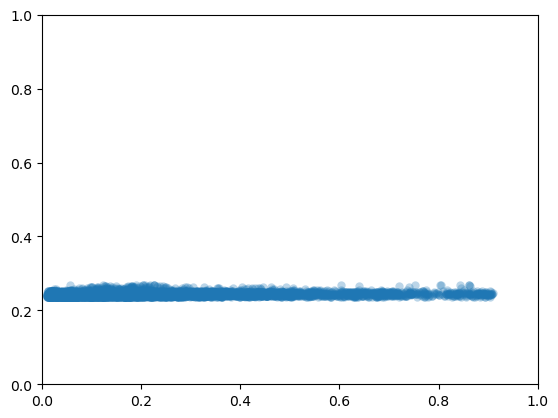

In [37]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y, y=y_hat, alpha=0.3, linewidth=0)

### Model 6 - Linear regression with uniform population and taking wave and current

In [39]:
# Load the model from file
file_name = model_dir.joinpath("thrust_tuning_lin_reg_4.joblib")
model_6 = load(str(file_name))

In [40]:
# Test model performance
y_hat = model_6.predict(X)
model_6_mse = mean_squared_error(y, y_hat)
model_6_r2  = r2_score(y, y_hat)
print("mse = {}".format(model_6_mse))
print("r2 = {}".format(model_6_r2))

mse = 0.033305680233491376
r2 = -0.03203199510856569


<AxesSubplot: >

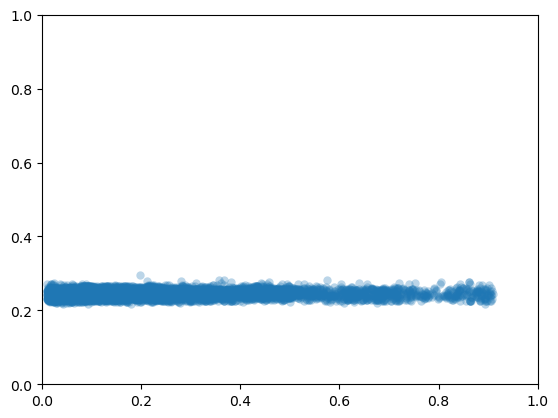

In [41]:
plt.axis([0,1,0,1])
sns.scatterplot(x=y, y=y_hat, alpha=0.3, linewidth=0)

## Summary

In [42]:
print("Model 1 mse = {}".format(model_1_mse))
print("Model 2 mse = {}".format(model_2_mse))
print("Model 3 mse = {}".format(model_3_mse))
print("Model 4 mse = {}".format(model_4_mse))
print("Model 5 mse = {}".format(model_5_mse))
print("Model 6 mse = {}".format(model_6_mse))

Model 1 mse = 0.0327205389180671
Model 2 mse = 0.03279205959580764
Model 3 mse = 0.035871450583258774
Model 4 mse = 0.0349380594514247
Model 5 mse = 0.032876862461201715
Model 6 mse = 0.033305680233491376
